In [1]:
!pip install pvlib

     |████████████████████████████████| 27.6 MB 54.3 MB/s 


In [2]:
import numpy as np
import math
import pandas as pd
from pvlib import solarposition as solar
import datetime
from matplotlib import pyplot as plt
import pytz
from skimage import draw
from random import randint

In [3]:
import os
import random
import numpy as np
from numpy import genfromtxt
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import sys
import shutil
import warnings

In [4]:
if 'google.colab' in str(get_ipython()):

  # To run in Gogogle Colab
  # You have to create a folder IFT6759 in your google drive 
  # and put all content of the folder ift-6759-forecast-project 

  #@title Mount your Google Drive

  %matplotlib inline
  %load_ext autoreload
  %autoreload 2

  from google.colab import drive
  #drive.mount('/content/gdrive')
  drive.mount("/content/gdrive", force_remount=True)

  folder = "/content/gdrive/MyDrive/IFT6759" #@param {type:"string"}
  !ln -Ts $folder /content/IFT6759 2> /dev/null

  # Add the assignment folder to Python path
  if '/content/IFT6759' not in sys.path:
      sys.path.insert(0, '/content/IFT6759')

  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/functions')
  import utils
  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/models')
  import SUNSET

else:

  import models.SUNSET as SUNSET
  import functions.utils as utils

Mounted at /content/gdrive


In [5]:
# define folder location

dir_path = os.getcwd()

if 'google.colab' in str(get_ipython()):
  dir_path = os.path.join(dir_path, "gdrive/MyDrive/IFT6759")

data_folder = os.path.join(dir_path, "data")
model_folder = os.path.join(dir_path, "models")

#define file location

images_trainval_path = os.path.join(data_folder,'images_trainval.npy')
pv_log_trainval_path = os.path.join(data_folder,'pv_log_trainval.npy')
datetime_trainval_path = os.path.join(data_folder,'datetime_trainval.npy')

images_test_path = os.path.join(data_folder,'images_test.npy')
pv_log_test_path = os.path.join(data_folder,'pv_log_test.npy')
datetime_test_path = os.path.join(data_folder,'datetime_test.npy')

In [8]:
# load PV output and images for the trainval set

pv_log_trainval = np.load(pv_log_trainval_path)
images_trainval = np.load(images_trainval_path)
#images_trainval = images_trainval.reshape(images_trainval.shape[0],3,64,64)
datetime_trainval = np.load(datetime_trainval_path, allow_pickle=True)

# load PV output and images for the test set

pv_log_test = np.load(pv_log_test_path)
images_test = np.load(images_test_path)
#images_test = images_test.reshape(images_test.shape[0],3,64,64)
datetime_test = np.load(datetime_test_path, allow_pickle=True)

In [7]:

# Loading data for initial results
# Image size: 64x64x3
datetime_trainval = np.load('/content/drive/MyDrive/photovoltaics/datetime_trainval.npy', allow_pickle=True)
images_trainval = np.load('/content/drive/MyDrive/photovoltaics/images_trainval.npy', allow_pickle=True)
datetime_test = np.load('/content/drive/MyDrive/photovoltaics/datetime_test.npy', allow_pickle=True)
images_test = np.load('/content/drive/MyDrive/photovoltaics/images_test.npy', allow_pickle=True)
print(images_trainval.shape)

FileNotFoundError: ignored

In [9]:
print(images_trainval.shape)

(92975, 64, 64, 3)


In [10]:
# Swapping BGR => RGB
images_trainval = images_trainval[:,:,:,::-1]
images_test = images_test[:,:,:,::-1]

In [11]:
# Returns a boolean matrix of img: a pixel is True if it is within r radius of (x,y)
def get_circle_coordinates(img, x, y, r):
    xx, yy = np.mgrid[:img.shape[0], :img.shape[1]]
    circle = (xx - x) ** 2 + (yy - y) ** 2
    circumsolar = np.logical_and(circle <= round(r**2), True)
    return circumsolar

In [12]:
# Coordinates for the Jen-Hsun Huang Engineering Center (location of the camera)
LATITUDE = 37.427940
LONGITUDE = -122.174220

# Radius of camera
R = 29

# Camera deviation angle from the due north
delta = 14

# x,y coordinates of the origin
O_x = 30
O_y = 30

# Calculate total number of pixels inside circle image
N_PIXELS_CIRCLE = np.sum(get_circle_coordinates(images_trainval[0], O_x, O_y, R))

In [13]:
# Calculate the NRBR (normalised red-blue ratio) of an image, pixel-by-pixel
# The image could be flattened (pixels, channels)
def NRBR(img):
    if len(img.shape) == 2:
        B = img[:,2]
        R = img[:,0]
    else:
        B = img[:,:,2]
        R = img[:,:,0]
    
    return (B-R)/(B+R+1e-4)

In [16]:
# Calculates the number of days from the start of the year
def day_of_year(dt):
    return (dt - datetime.datetime(dt.year, 1, 1)).days + 1

# Sun position identification algorithm
def sun_position(img, dt):
    d = day_of_year(dt)
    dt_index = pd.DatetimeIndex([dt], tz=pytz.timezone('US/Pacific'))
    #B = (360/365) * (d - 81)
    #eot = 9.87 * math.sin(2 * math.radians(B)) - 7.53 * math.cos(math.radians(B)) - 1.5 * math.sin(math.radians(B))
    #eot = solar.equation_of_time_spencer71(d)
    #hour_angle = solar.hour_angle(times=dt_index, longitude=LONGITUDE, equation_of_time=eot)
    #declination = solar.declination_spencer71(d)

    # Use get_solarposition from the pvlib library
    pos = solar.get_solarposition(dt_index, LATITUDE, LONGITUDE)
    zenith = pos.zenith[0]
    azimuth = pos.azimuth[0]
    # print(zenith, azimuth)
    
    # zenith & azimuth in radians
    #zenith = solar.solar_zenith_analytical(LATITUDE, hour_angle, declination)
    #azimuth = solar.solar_azimuth_analytical(LATITUDE, hour_angle, declination, zenith)
    # print(math.degrees(zenith), math.degrees(azimuth))

    rho = zenith / 90 * R
    theta = azimuth - delta + 90
    
    sun_x = round(O_x - rho * math.sin(math.radians(theta)))
    sun_y = round(O_y + rho * math.cos(math.radians(theta)))

    return sun_x, sun_y

In [17]:
# Load the "Clear Sky Library" (and identifies sun positions for all the images)
def load_CSL():
    # Find image indices for dates corresponding to CSL
    date_queries = set([(5,20),(8,15),(9,23),(10,22)])
    trainval_indices = []
    test_indices = []
    for i, dt in enumerate(datetime_trainval):
        date = dt.month, dt.day
        if date in date_queries:
            trainval_indices.append(i)
    for i, dt in enumerate(datetime_test):
        date = dt.month, dt.day
        if date in date_queries:
            test_indices.append(i)
    
    # Extracting CSL images
    tv_CSL = images_trainval[trainval_indices]
    test_CSL = images_test[test_indices]
    CSL = np.concatenate((tv_CSL, test_CSL), axis=0)
    tv_CSL_dt = datetime_trainval[trainval_indices]
    test_CSL_dt = datetime_test[test_indices]
    CSL_datetimes = np.concatenate((tv_CSL_dt, test_CSL_dt))

    # Determining solar position for each CSL image
    sun_positions = []
    for i, img in enumerate(CSL):
        dt = CSL_datetimes[i]
        sun_pos = sun_position(img, dt)
        sun_positions.append(sun_pos)

    return CSL, sun_positions

CSL, CSL_sun_pos = load_CSL()

# Find a clear sky image in the CSL that has the sun at position x,y
def find_CSL(x, y):
    # Get exact match
    if (x,y) in CSL_sun_pos:
        return CSL[CSL_sun_pos.index((x,y))]
    else:
        r = 1
        # Search the pixels outwards
        while r <= 10:
            for i in range(-r, r+1):
                for j in range(-r, r+1):
                    if j == -r or j == r or i == -r or i == r:
                        try:
                            return CSL[CSL_sun_pos.index((x+i, y+j))]
                        except:
                            pass
            r += 1
    raise ValueError(f'CSL image could not be found within radius {r-1} of ({x},{y}).')

In [18]:
# Calculate the cloudiness (i.e. the fraction of cloud pixels in the sky)
# Input is a boolean array: True for cloud pixels, False for sky pixels
def calculate_cloudiness(cloud_pixels):
    return np.sum(cloud_pixels) / N_PIXELS_CIRCLE

In [19]:
# Fixed Threshold Method
def fixed_threshold(NRBR):
    return calculate_cloudiness(NRBR <= 0.05)

In [20]:
# modified Threshold with Background Subtraction Method
def modified_threshold_with_BS(img, dt):
    NRBR_original = NRBR(img)
    sun_x, sun_y = sun_position(img, dt)
    clear_sky = find_CSL(sun_x, sun_y)
    delta_NRBR = np.abs(NRBR_original - NRBR(clear_sky))
    inside_circle = get_circle_coordinates(img, O_x, O_y, R)
    # True means cloud, False means sky (or background!)
    cloud_pixels = np.logical_and(delta_NRBR >= 0.175, inside_circle)
    cloudiness = calculate_cloudiness(cloud_pixels)

    if cloudiness < 0.045:
        return cloudiness
    elif cloudiness < 0.35:
        # Pixels outside the circumsolar area
        circumsolar = get_circle_coordinates(img, sun_x, sun_y, 7)
        outside = ~circumsolar & inside_circle
        NRBR_outside = NRBR(img[outside])
        return fixed_threshold(NRBR_outside)
    else:
        return fixed_threshold(NRBR_original)

In [21]:
"""
Classify the cloudiness of an image into 3 classes (sunny, cloudy, overcast)
or 2 classes (just sunny and cloudy). 3 classes is the default option as it was
found to be optimal. Returns an integer between 0 and 2.
"""
def cloudiness_classification(img, dt, n_classes=3):
    sun_x, sun_y = sun_position(img, dt)
    cloudiness = modified_threshold_with_BS(img, dt)
    if n_classes == 3:
        if cloudiness <= 0.15: # cloudiness <= 0.16:
            return 0, cloudiness
        elif cloudiness <= 0.6: # cloudiness <= 0.595:
            return 1, cloudiness
        else:
            # Sun Area Mean Pixel Intensity
            sun_area = get_circle_coordinates(img, sun_x, sun_y, 2)
            #sun_area_pixels = img[sun_area[0],sun_area[1],:]
            #print(sun_area.sum())
            R,G,B = np.multiply(sun_area,img[:,:,0]), np.multiply(sun_area,img[:,:,1]), np.multiply(sun_area,img[:,:,2])
            I = 0.229 * R + 0.587 * G + 0.114 * B
            SAMPI = I.sum()/sun_area.sum()
            if SAMPI >= 195:
              return 1, cloudiness  
            else: 
              return 2, cloudiness
    elif n_classes == 2:
          if cloudiness <= 0.25:
              return 0, cloudiness  
          else: 
              return 1, cloudiness

In [22]:
# Test Labels

class_test = pd.DataFrame(columns=['label'])

for i in range(len(images_test)):
    #i = randint(0, len(images_test)-1)
    img = images_test[i]
    dt = datetime_test[i]
    #print(f"Date & Time: {dt}")
    #print(f"Identified Solar Position: {sun_position(img, dt)}")

    classes = ["Sunny", "Cloudy", "Overcast"]
    prediction, cloudiness = cloudiness_classification(img, dt)
    
    class_test = class_test.append({'label': classes[prediction]}, ignore_index=True)
    
    #print(f"Cloudiness (according to MTw/BS): {cloudiness:.2f}")
    #print(f"Classification: {classes[prediction]}")

    #print(n)
    #print(class_test)
    #plt.imshow(img)
    #plt.show()
    #print()

class_test.value_counts()

label   
Sunny       5891
Cloudy      2991
Overcast    1028
dtype: int64

In [ ]:
# Train Labels

class_train = pd.DataFrame(columns=['label'])

for i in range(len(images_trainval)):
    #i = randint(0, len(images_test)-1)
    img = images_trainval[i]
    dt = datetime_trainval[i]
    #print(f"Date & Time: {dt}")
    #print(f"Identified Solar Position: {sun_position(img, dt)}")

    classes = ["Sunny", "Cloudy", "Overcast"]
    prediction, cloudiness = cloudiness_classification(img, dt)
    
    class_train = class_train.append({'label': classes[prediction]}, ignore_index=True)
    
    #print(f"Cloudiness (according to MTw/BS): {cloudiness:.2f}")
    #print(f"Classification: {classes[prediction]}")

    #print(n)
    #print(class_test)
    #plt.imshow(img)
    #plt.show()
    #print()

class_train.value_counts()

label 
Sunny     63128
Cloudy    29847
dtype: int64

In [ ]:
dir_path = os.getcwd()

if 'google.colab' in str(get_ipython()):
  dir_path = os.path.join(dir_path, "gdrive/MyDrive/IFT6759")

data_folder = os.path.join(dir_path, "data")

train_label_path = os.path.join(data_folder,'train_label_3_classes_d.csv')
class_train.to_csv(train_label_path)

test_label_path = os.path.join(data_folder,'test_label_3_classes_d.csv')
class_test.to_csv(test_label_path)

Date & Time: 2018-02-01 11:23:00
Identified Solar Position: (45, 21)


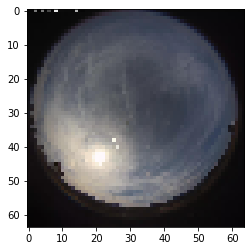


Date & Time: 2018-02-28 16:59:00
Identified Solar Position: (44, 51)


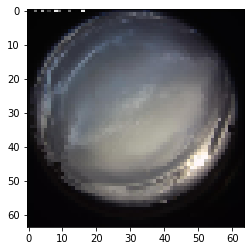


Date & Time: 2017-10-07 09:16:00
Identified Solar Position: (35, 9)


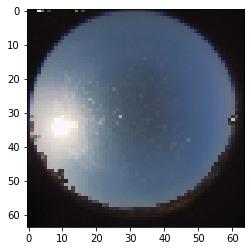


Date & Time: 2017-07-05 09:06:00
Identified Solar Position: (25, 13)


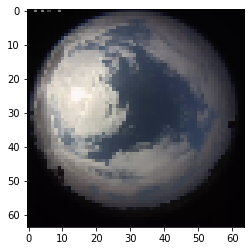


Date & Time: 2017-10-07 10:05:00
Identified Solar Position: (38, 13)


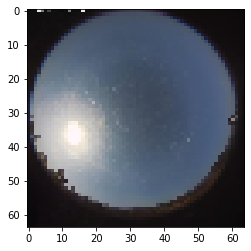

In [ ]:
# Initial results
for n in range(5):
    i = randint(0, len(images_test)-1)
    img = images_test[i]
    dt = datetime_test[i]
    print(f"Date & Time: {dt}")
    print(f"Identified Solar Position: {sun_position(img, dt)}")

    #classes = ["Sunny", "Cloudy", "Overcast"]
    #prediction, cloudiness = cloudiness_classification(img, dt)
    #print(f"Cloudiness (according to MTw/BS): {cloudiness:.2f}")
    #print(f"Classification: {classes[prediction]}")
    plt.imshow(img)
    plt.show()
    print()